# Try out Bayesian update to environmental estimate

In [1]:
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
from hierarchical_normal_belk import hierarchical_normal
#%%

In [2]:
rng=np.random.Generator(np.random.PCG64(1234))
#%%
size = 250
mean_tempC_Km = 6.5/1000
max_alt_Km = 13
lat = np.arange(0, size)
long = np.arange(0, size)
alt = np.arange(0, max_alt_Km)*1000
#%%

In [3]:
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]
#%%


Baseline thermal along latitude

In [4]:
base_sigma = .05
samp_lat= pd.DataFrame(sample_AR_signal(size, 0.5, mu=2, sigma=base_sigma))
# %%

Extend along longitude

In [5]:
samp = sample_AR_signal(size, 0.5, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
# %%


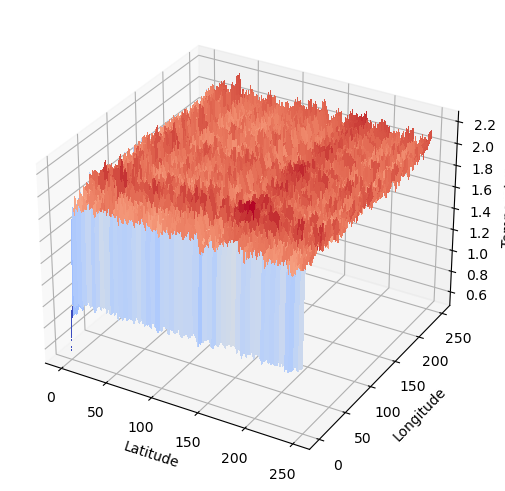

In [6]:
def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
# keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)

# %%

Add trend on top of the AR variation -- to baseline thermal

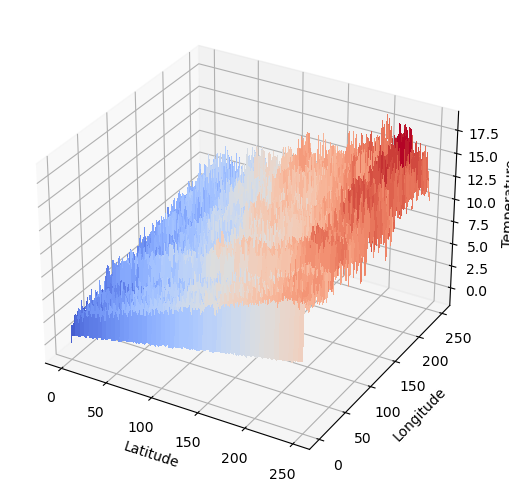

In [7]:
lat_inc_max = 10
long_inc_mu, long_inc_std = .01, .1

def add_inc_MA(size, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size,size), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)


plot_temperature_env(samp_inc)
# %%

Extend into atmosphere

In [8]:
#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/10, size=max_alt_Km)
# Temp at altitude = base temp - tempC_km * altitude
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * np.arange(max_alt_Km)*1000, (250,250,13)
    ).T
)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)

# %%

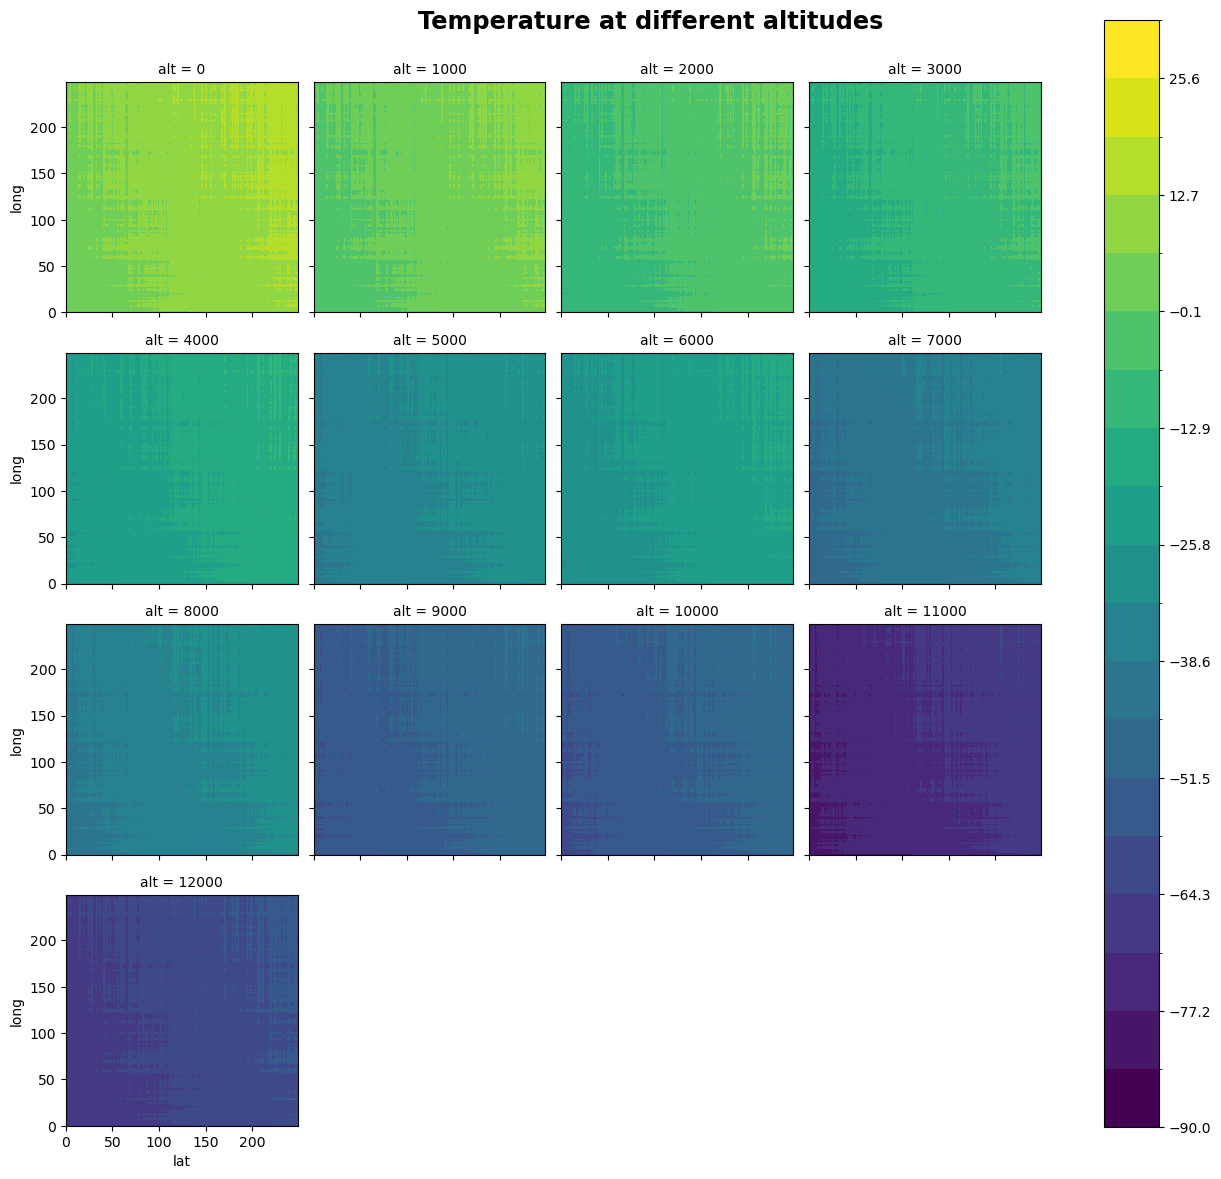

In [9]:
xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)

xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})

Calculate pressure based on baseline temp field and assumed L; 

- []TODO: refactor equation to use the previously calculated temperatures

In [10]:
# %%
#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    T = T +273.15
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    return P0 * (T / T0) ** (g0 / (R * L.mean()))


pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = xr_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)
   

In [11]:
pressure

<xarray.DataArray (lat: 250, long: 250, alt: 13)>
array([[[1.01325000e+05, 1.24759289e+03, 7.44794908e+00, ...,
         7.04703499e-16, 2.04932565e-23, 1.51520953e-19],
        [1.01325000e+05, 1.24276446e+03, 7.38480662e+00, ...,
         6.72963535e-16, 1.91732127e-23, 1.43295478e-19],
        [1.01325000e+05, 1.28097268e+03, 7.89244074e+00, ...,
         9.64198044e-16, 3.22283695e-23, 2.21484086e-19],
        ...,
        [1.01325000e+05, 1.31695940e+03, 8.38731298e+00, ...,
         1.33909112e-15, 5.17687567e-23, 3.29609167e-19],
        [1.01325000e+05, 1.31292102e+03, 8.33096698e+00, ...,
         1.29124881e-15, 4.91220869e-23, 3.15411770e-19],
        [1.01325000e+05, 1.29637538e+03, 8.10225708e+00, ...,
         1.11104775e-15, 3.95454516e-23, 2.62948634e-19]],

       [[1.01325000e+05, 1.25893654e+03, 7.59743876e+00, ...,
         7.84706245e-16, 2.39369095e-23, 1.72594610e-19],
        [1.01325000e+05, 1.26103247e+03, 7.62523564e+00, ...,
         8.00363023e-16, 2.46297185e-23, 1.76773324e-19],
        [1.01325000e+05, 1.30300471e+03, 8.19348031e+00, ...,
         1.18030090e-15, 4.31507116e-23, 2.82914926e-19],
...
        [1.01325000e+05, 1.50249740e+03, 1.11995948e+01, ...,
         6.34133079e-15, 4.85705217e-22, 2.16063598e-18],
        [1.01325000e+05, 1.50442252e+03, 1.12310865e+01, ...,
         6.43747659e-15, 4.96321945e-22, 2.20027098e-18],
        [1.01325000e+05, 1.48459361e+03, 1.09090082e+01, ...,
         5.50774062e-15, 3.96648761e-22, 1.82237277e-18]],

       [[1.01325000e+05, 1.36683445e+03, 9.10019111e+00, ...,
         2.07882952e-15, 9.75950470e-23, 5.61169751e-19],
        [1.01325000e+05, 1.42054077e+03, 9.90314521e+00, ...,
         3.27651638e-15, 1.87919129e-22, 9.72819742e-19],
        [1.01325000e+05, 1.49410489e+03, 1.10628660e+01, ...,
         5.93725950e-15, 4.41855856e-22, 1.99543730e-18],
        ...,
        [1.01325000e+05, 1.48469121e+03, 1.09105810e+01, ...,
         5.51200035e-15, 3.97089802e-22, 1.82407579e-18],
        [1.01325000e+05, 1.48235928e+03, 1.08730339e+01, ...,
         5.41103371e-15, 3.86676033e-22, 1.78378345e-18],
        [1.01325000e+05, 1.46272260e+03, 1.05596327e+01, ...,
         4.62523863e-15, 3.08580342e-22, 1.47570231e-18]]])
Coordinates:
  * lat      (lat) int32 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
  * long     (long) int32 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
  * alt      (alt) int32 0 1000 2000 3000 4000 ... 8000 9000 10000 11000 12000

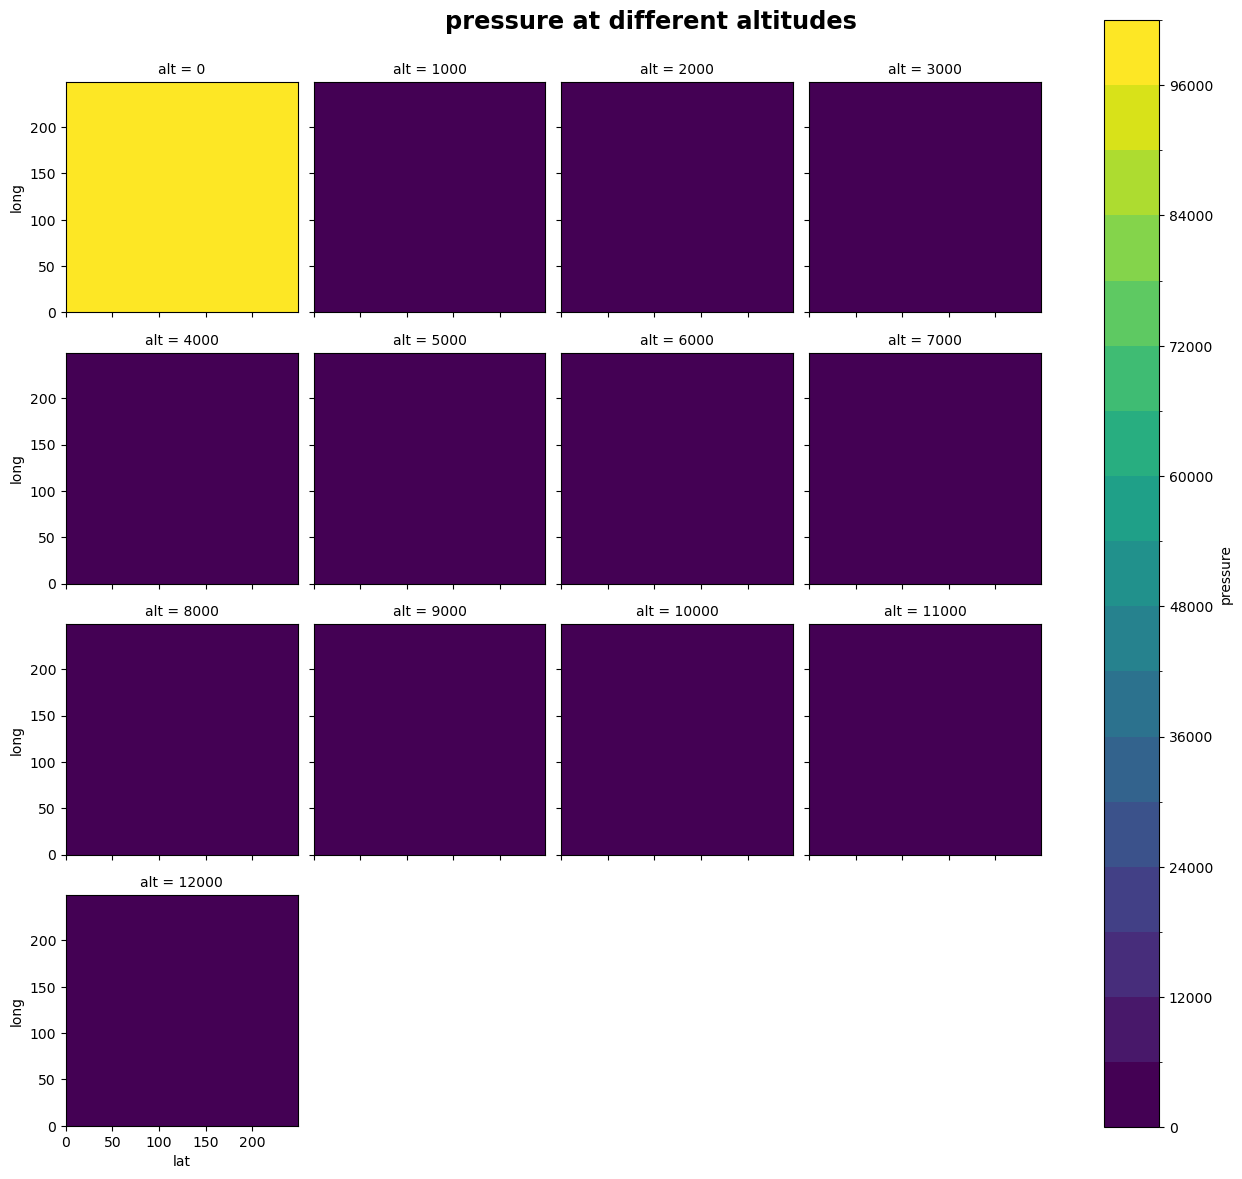

In [12]:
 
# %%
xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("pressure")]
     )
# %%
xr_temp_pres.pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)
# %%

# make trajectory and get corresponding temp and pres

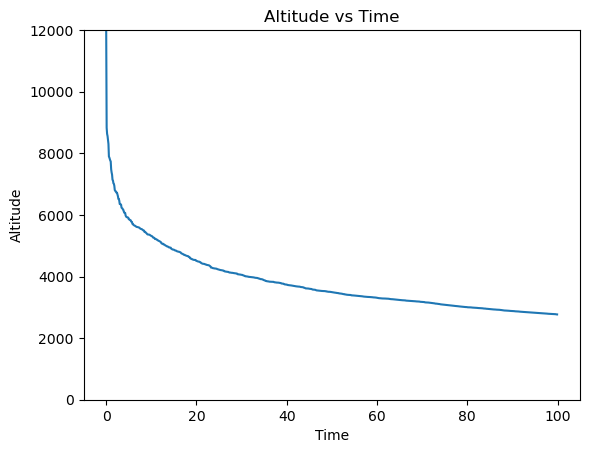

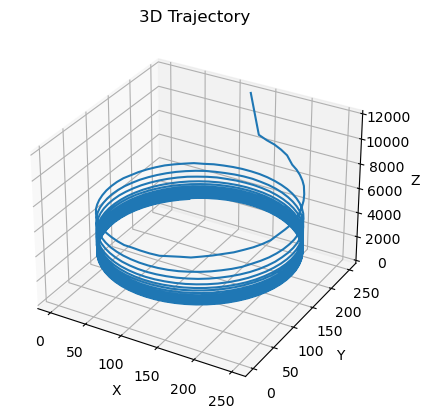

In [13]:
# make Z = a function of time and  X = sin of time and y = cos of time

# %%
time = np.arange(0, 100, 0.1)
release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1
x = (np.sin(time) +1) * 250/2
y = (np.cos(time) +1 ) * 250/2
#create samples from normal distribution and sort them
samples = stats.norm.rvs(loc=0, scale=10, size=len(time), random_state=None)
samples = stats.weibull_max.rvs(1, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
#steps = 1/(1+np.exp(-samples)) #sigmoid function
steps = samples/(samples.max()-samples.min()) /1.3  #normalize
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()
# %%

In [14]:
xr_temp_pres

<xarray.Dataset>
Dimensions:      (lat: 250, long: 250, alt: 13)
Coordinates:
  * lat          (lat) int32 0 1 2 3 4 5 6 7 ... 242 243 244 245 246 247 248 249
  * long         (long) int32 0 1 2 3 4 5 6 7 ... 243 244 245 246 247 248 249
  * alt          (alt) int32 0 1000 2000 3000 4000 ... 9000 10000 11000 12000
Data variables:
    Temperature  (lat, long, alt) float64 0.09039 -6.451 ... -70.74 -61.07
    pressure     (lat, long, alt) float64 1.013e+05 1.248e+03 ... 1.476e-18

In [15]:
#select from xarray the temperature at the pressure of the trajectory
xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z)#, method='nearest')
xr_traj_env.interpolate_na(dim='time', method='linear', fill_value="extrapolate")

<xarray.Dataset>
Dimensions:      (time: 1000)
Coordinates:
    long         (time) float64 250.0 249.4 247.5 244.4 ... 209.3 218.1 225.9
    alt          (time) float64 1.2e+04 8.832e+03 ... 2.77e+03 2.769e+03
  * time         (time) float64 0.0 0.1 0.2 0.3 0.4 ... 99.5 99.6 99.7 99.8 99.9
    lat          (time) float64 125.0 137.5 149.8 161.9 ... 32.68 41.55 51.26
Data variables:
    Temperature  (time) float64 -47.03 -45.3 -43.58 ... -12.05 -12.29 -11.16
    pressure     (time) float64 1.527e-09 2.389e-09 3.251e-09 ... 2.25 2.341

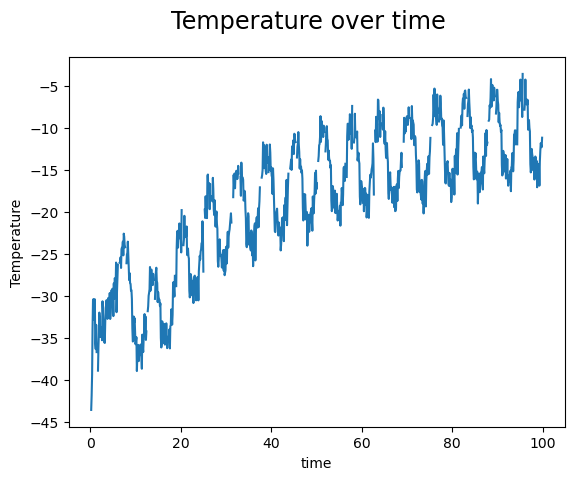

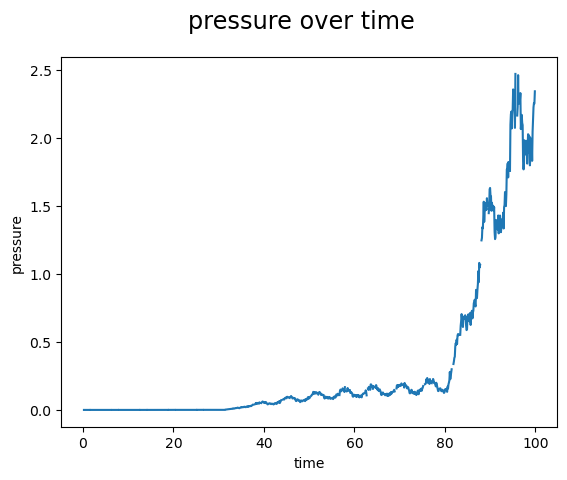

In [16]:
xr_traj_env.Temperature.plot()
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
xr_traj_env.pressure.plot()
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()


In [17]:
#add wind direction and speed then its velocity relvant to the trajectory
wind_direction = 180 #degrees from north is 0, from east is 90, from south is 180, from west is 270
wind_speed = 10 #m/s #TODO: add wind speed as a function of altitude and lat long
wind_speed_long = wind_speed * np.cos(np.deg2rad(wind_direction))
wind_speed_lat = wind_speed * np.sin(np.deg2rad(wind_direction))
wind_speed_z = 0
display('wind_speed_long',wind_speed_long, 
        'wind_speed_lat',wind_speed_lat, 
        'wind_speed_z',wind_speed_z)
# %%

'wind_speed_long'

-10.0

'wind_speed_lat'

1.2246467991473533e-15

'wind_speed_z'

0

In [18]:
#add wind velocity relvant to the trajectory
xr_traj_env['wind_speed_long'] = wind_speed_long
xr_traj_env['wind_speed_lat'] = wind_speed_lat
xr_traj_env['wind_speed_z'] = wind_speed_z
xr_traj_env['wind_speed'] = np.sqrt(wind_speed_long**2 + wind_speed_lat**2 + wind_speed_z**2)
xr_traj_env['wind_direction'] = wind_direction
xr_traj_env=xr_traj_env.interpolate_na(dim='time', method='linear', limit=None, use_coordinate=True, fill_value='extrapolate')
xr_traj_env
# %%

<xarray.Dataset>
Dimensions:          (time: 1000)
Coordinates:
    long             (time) float64 250.0 249.4 247.5 ... 209.3 218.1 225.9
    alt              (time) float64 1.2e+04 8.832e+03 ... 2.77e+03 2.769e+03
  * time             (time) float64 0.0 0.1 0.2 0.3 0.4 ... 99.6 99.7 99.8 99.9
    lat              (time) float64 125.0 137.5 149.8 ... 32.68 41.55 51.26
Data variables:
    Temperature      (time) float64 -47.03 -45.3 -43.58 ... -12.05 -12.29 -11.16
    pressure         (time) float64 1.527e-09 2.389e-09 3.251e-09 ... 2.25 2.341
    wind_speed_long  float64 -10.0
    wind_speed_lat   float64 1.225e-15
    wind_speed_z     int32 0
    wind_speed       float64 10.0
    wind_direction   int32 180

# Using average values per Km; TODO: find more principled way to remove autocorrelation 

In [19]:
#!! conda install -c conda-forge flox
import flox
from flox.xarray import xarray_reduce

In [20]:
bins_alt = np.linspace(alt.min(), alt.max(), 11)
bins_lat =[lat.min(), lat.mean(),lat.max()] #quadrents
bins_long = [long.min(), long.mean(), long.max()]# quadrents
bins_time = np.arange(time.min(), time.max()+1, 10)

In [21]:
bins_time

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [22]:
#grouping lat long and alt
if False:
  grp_traj_env=xarray_reduce(xr_traj_env.drop_vars(['wind_speed_long', 'wind_speed_lat', 'wind_speed_z', 'wind_speed', 'wind_direction']),
               'alt', 'lat', 'long',
                 func='mean',
                 expected_groups=(
                            pd.IntervalIndex.from_breaks(bins_alt, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_lat, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_long, closed='left')
                        ))
  grp_traj_env

In [23]:
#grouping lat long and alt and time
grp_traj_env=xarray_reduce(xr_traj_env.drop_vars(['wind_speed_long', 'wind_speed_lat', 'wind_speed_z', 'wind_speed', 'wind_direction']),
               'alt', 'lat', 'long', 'time',
                 func='mean',
                 expected_groups=(
                            pd.IntervalIndex.from_breaks(bins_alt, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_lat, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_long, closed='left'),
                            pd.IntervalIndex.from_breaks(bins_time, closed='left')
                        ))
if False:
    grp_traj_env.sel(time_bins=pd.IntervalIndex.from_breaks([0, 10], closed='left'),
                 long_bins=pd.IntervalIndex.from_breaks([124.5, 249.0], closed='left'),
                 alt_bins=pd.IntervalIndex.from_breaks([10800, 12000], closed='left'))
grp_traj_env = grp_traj_env.stack(alt_lat_long_time=(
    'alt_bins', 
    'lat_bins', 
    'long_bins',
    'time_bins')).dropna(dim='alt_lat_long_time')

grp_traj_env.coords

Coordinates:
  * alt_lat_long_time  (alt_lat_long_time) object MultiIndex
  * alt_bins           (alt_lat_long_time) object [2400.0, 3600.0) ... [8400....
  * lat_bins           (alt_lat_long_time) object [0.0, 124.5) ... [124.5, 24...
  * long_bins          (alt_lat_long_time) object [0.0, 124.5) ... [124.5, 24...
  * time_bins          (alt_lat_long_time) object [40.0, 50.0) ... [0.0, 10.0)

In [24]:

#xarray group by ten minute... loose other dimensions
if False:
    grp_traj_env = xr_traj_env.groupby_bins(bins=np.linspace(0, 100, 11), group='time',squeeze=False).mean(skipna=True)

    grp_traj_env

In [25]:
#my_struct=my_struct.assign_coords({'coordA':('coordA',new_values,my_struct.coordA.attrs)})


In [26]:
with pm.Model(coords = {'Alt': np.flip(np.unique(grp_traj_env.alt.values))}) as thermal:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', (np.unique(grp_traj_env.alt.values)), dims='Alt' )
    Temp_ = pm.ConstantData('Temperature_Samples', grp_traj_env.Temperature.values, dims='Alt' )
    #prior on effect of altitude on temp
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=6, sigma=1)
    #prior on temp
    #TODO: PULL FROM DATABASE into a pm.Interpolated
    #mu = hierarchical_normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    mu = pm.Normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    
    #prior on error variation
    sigma=pm.Exponential('model_error', 1/0.5)
    #adjusted temp - normal dist error term
    obs = pm.Normal('obs', mu=mu, sigma=sigma, 
                    observed = Temp_, dims='Alt')
pm.model_to_graphviz(thermal)

AttributeError: 'Dataset' object has no attribute 'alt'

Sampling: [Alt_effect_temp_Km, model_error, obs, temperature_mean]


<Axes: xlabel='obs / obs'>

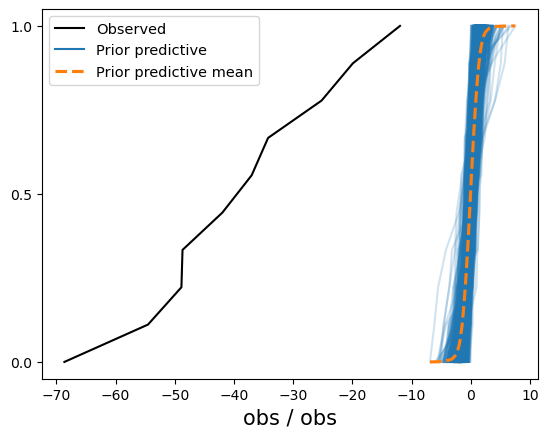

In [ ]:
with thermal:
    idata = pm.sample_prior_predictive(1000)
az.plot_ppc(idata, group='prior', kind='cumulative')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alt_effect_temp_Km, temperature_mean, model_error]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 42 seconds.


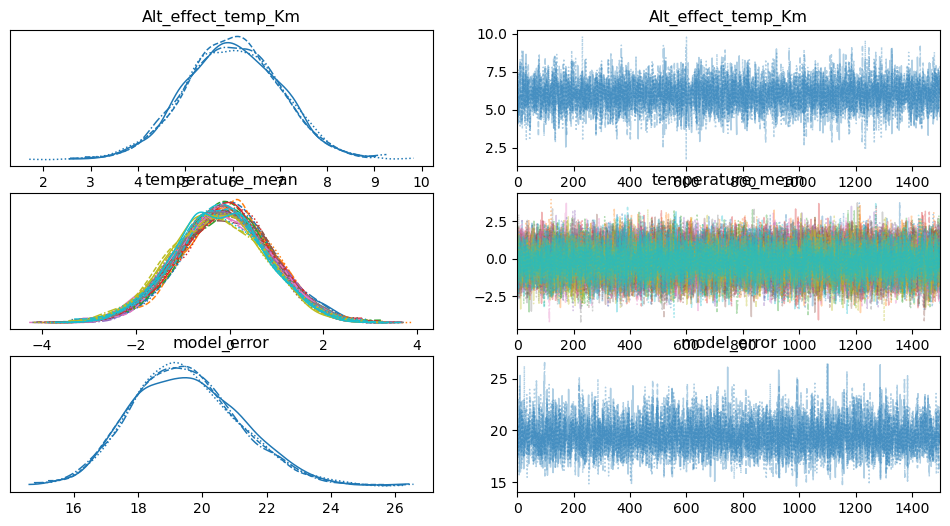

In [ ]:
with thermal:
    idata.extend(pm.sample(1500, tune=1500,  target_accept=.96))
    az.plot_trace(idata)

# Tryout pressure and altitude

In [28]:
[i for i in np.arange(grp_traj_env.sizes['alt_lat_long_time'])]
coords={'alt_lat_long_time':
                      np.arange(grp_traj_env.sizes['alt_lat_long_time'], dtype=int)
                      }
coords

{'alt_lat_long_time': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51])}

c:\Users\willi\OneDrive\Documents\GitHub\Weather\hierarchical_normal_belk.py:72: FutureWarning: The `testval` argument is deprecated; use `initval`.
  σ = pm.HalfNormal(f'σ_{name}', sigma=sigma, dims=dims_sigma,
c:\Users\willi\OneDrive\Documents\GitHub\Weather\hierarchical_normal_belk.py:72: FutureWarning: The `testval` argument is deprecated; use `initval`.
  σ = pm.HalfNormal(f'σ_{name}', sigma=sigma, dims=dims_sigma,


used t[0]
<class 'pytensor.tensor.var.TensorVariable'>


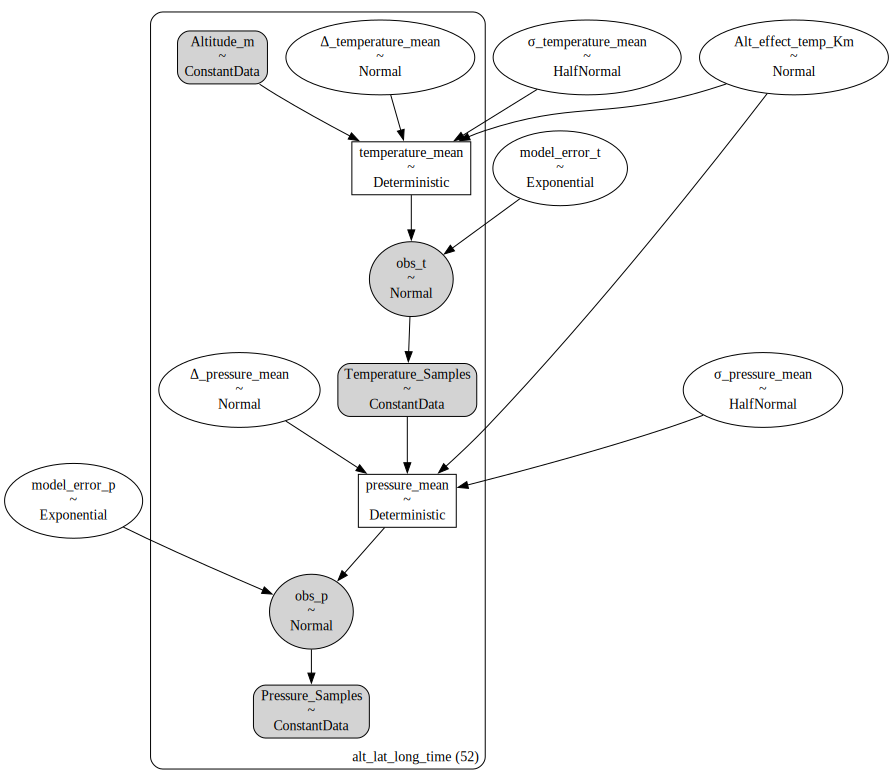

In [30]:
with pm.Model(coords=coords) as thermal_pres:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', [bin_item.mid 
                                          for bin_item in grp_traj_env.alt_bins.values], 
                                          dims='alt_lat_long_time' )
    Temp_ = pm.ConstantData('Temperature_Samples', grp_traj_env.Temperature.values, dims='alt_lat_long_time' )
    Pres_ = pm.ConstantData('Pressure_Samples', grp_traj_env.pressure.values, dims='alt_lat_long_time' )
    #prior on effect of altitude on temp
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=6, sigma=2)
    #prior on temp
    #TODO: PULL FROM DATABASE into a pm.Interpolated
    mu_mu_t = 0.0 - Alt_effect_temp/1000 * Alt_
    mu_t = hierarchical_normal('temperature_mean', mu= mu_mu_t, sigma = 2, dims='alt_lat_long_time')
    mu_p = hierarchical_normal('pressure_mean', mu= add_barometric_effects(T = Temp_, 
                                 L = Alt_effect_temp/1000, 
                                 H = Alt_,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598),
                               sigma = 10_000, dims='alt_lat_long_time')
    #P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/0.5)
    sigma_p=pm.Exponential('model_error_p', 1/1000)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t, 
                    observed = Temp_, dims='alt_lat_long_time')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p, 
                    observed = Pres_, dims='alt_lat_long_time')
    
pm.model_to_graphviz(thermal_pres)

Sampling: [Alt_effect_temp_Km, model_error_p, model_error_t, obs_p, obs_t, Δ_pressure_mean, Δ_temperature_mean, σ_pressure_mean, σ_temperature_mean]


array([<Axes: xlabel='obs_t / obs_t'>, <Axes: xlabel='obs_p / obs_p'>],
      dtype=object)

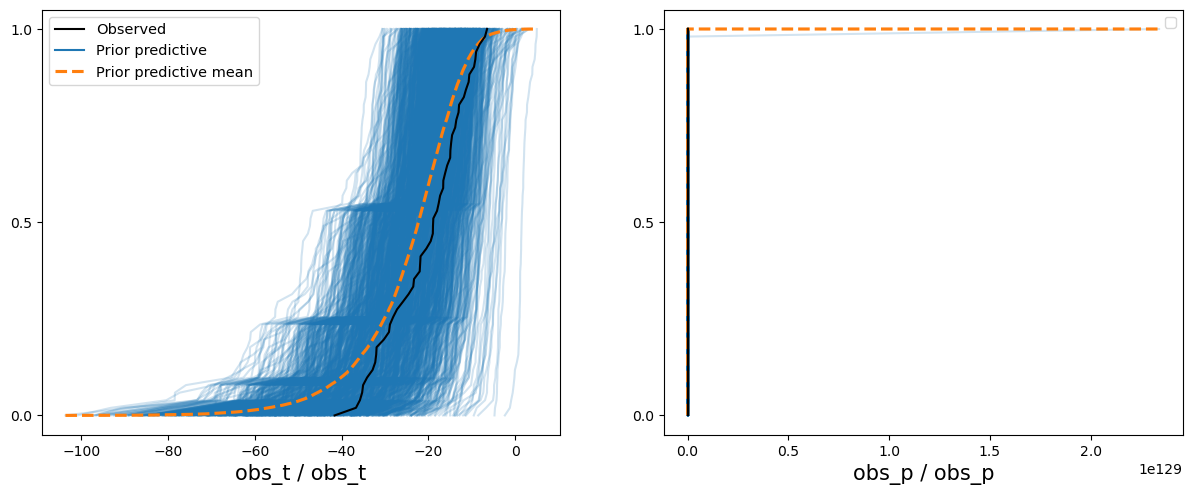

In [31]:
with thermal_pres:
    idata2 = pm.sample_prior_predictive(1000)
az.plot_ppc(idata2, group='prior', kind='cumulative')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alt_effect_temp_Km, Δ_temperature_mean, σ_temperature_mean, Δ_pressure_mean, σ_pressure_mean, model_error_t, model_error_p]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 78 seconds.


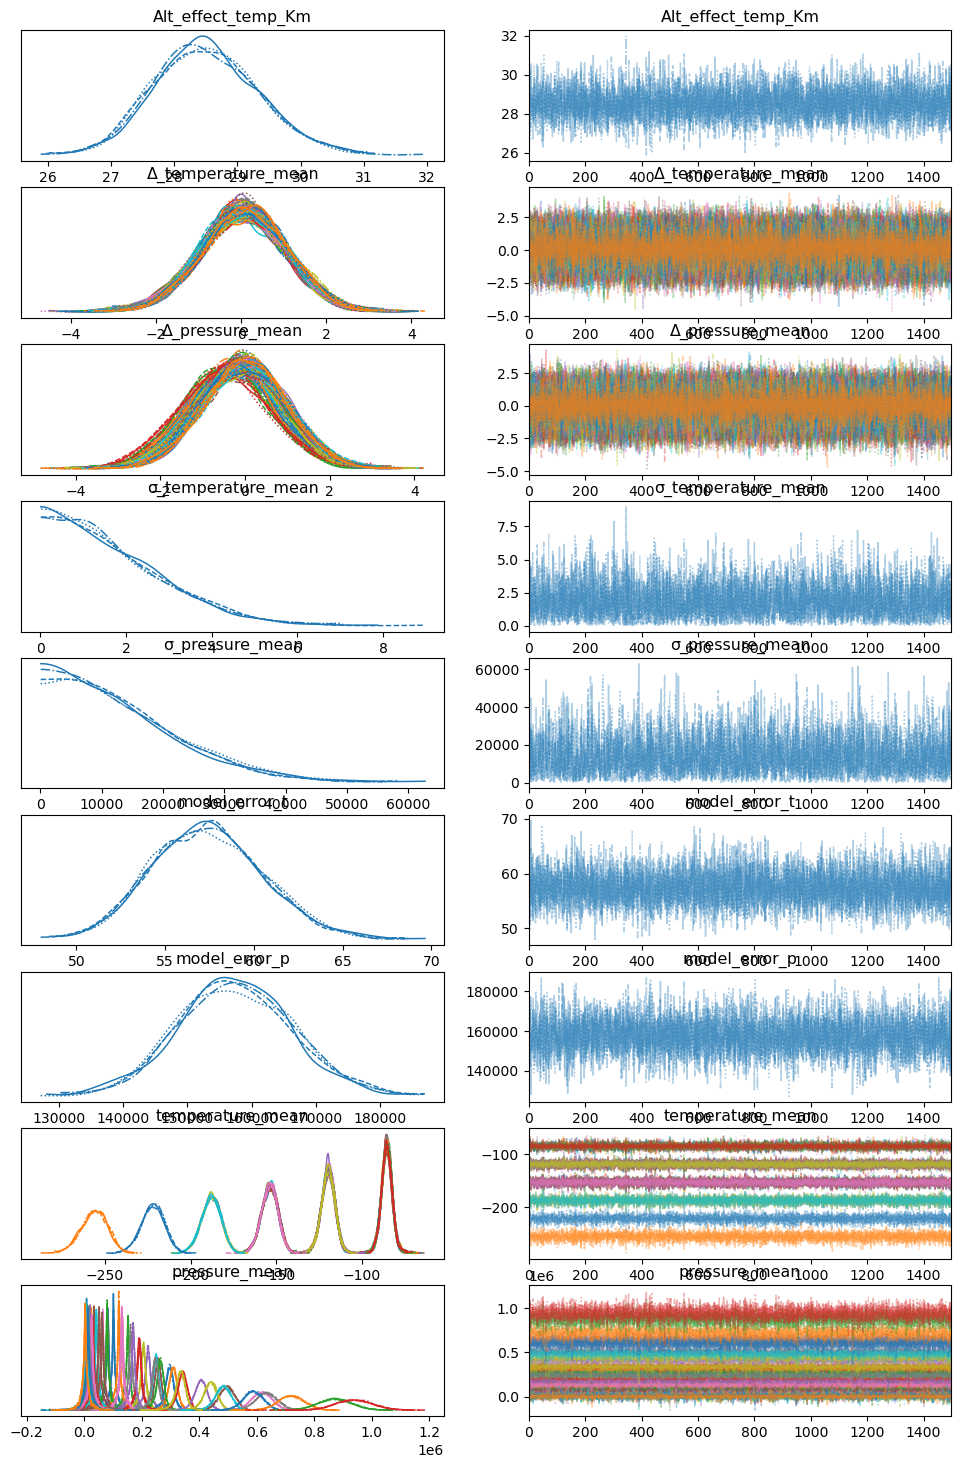

In [32]:
with thermal_pres:
    idata2.extend(pm.sample(1500, tune=1500, target_accept=.96))
    az.plot_trace(idata2)
    

In [33]:
idata2

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([<Axes: >], dtype=object)

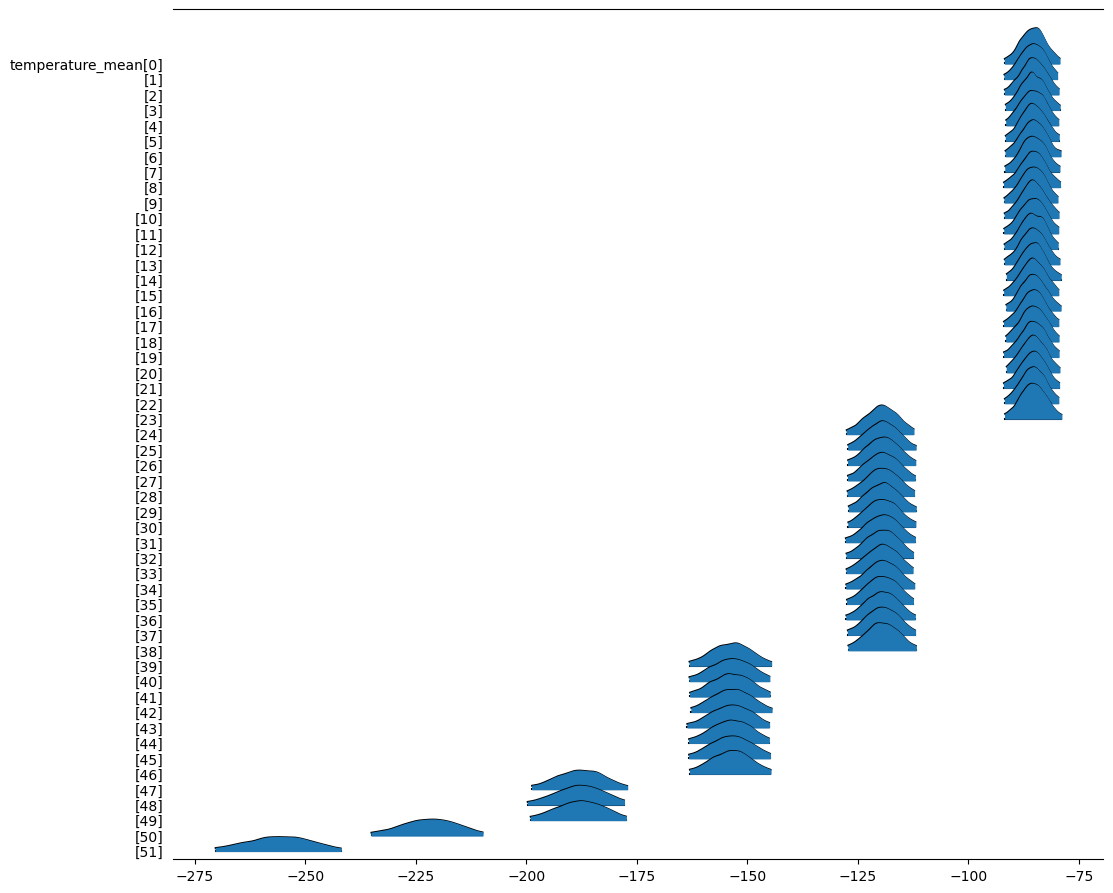

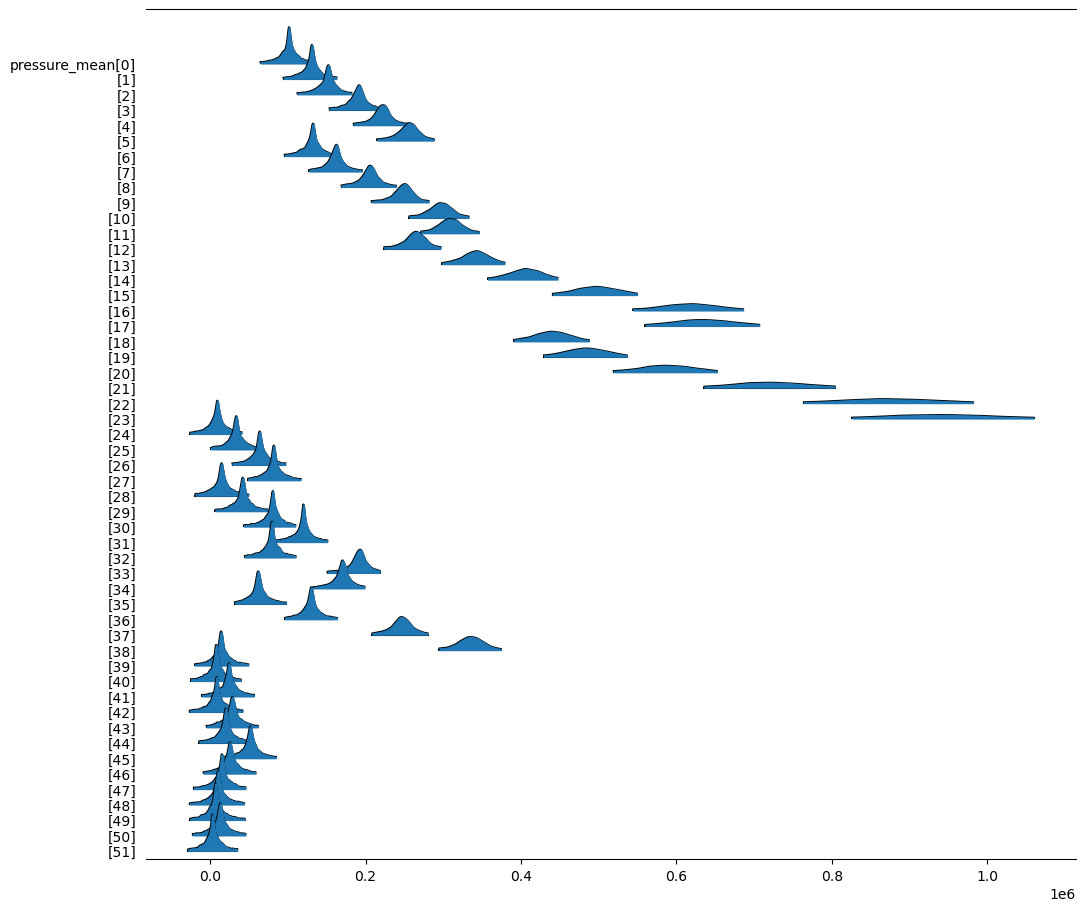

In [34]:
az.plot_forest(idata2, var_names=['temperature_mean'],kind='ridgeplot', combined=True)
az.plot_forest(idata2, var_names=['pressure_mean'],kind='ridgeplot', combined=True)